# Sandbox

You can run Aymara evals in a sandbox environment to test functionality without triggering real model calls or incurring costs. Sandbox mode returns mock responses, which are useful for validating your eval setup—prompt structure, formatting, and logic—before running against actual models.

This guide walks you through running a sandbox eval:

1. [Create an eval](#create-an-eval)
2. [Get eval responses](#get-eval-responses)
3. [Score eval responses](#score-eval-responses)
4. [Analyze eval results](#analyze-eval-results)

For information not in this user guide, refer to our [FAQ](https://docs.aymara.ai/faq.html).

---

## 0. Initialize Client

In [ ]:
import asyncio

import dotenv
import pandas as pd

from aymara_ai import AymaraAI
from aymara_ai.lib.df import to_prompts_df, to_scores_df, to_reports_df, to_df
from aymara_ai.lib.plot import eval_pass_stats, graph_eval_stats
from aymara_ai.lib.async_utils import wait_until_complete


dotenv.load_dotenv(override=True)
pd.set_option("display.max_colwidth", None)

# This assumes `AYMARA_AI_API_KEY` is stored as an env variable
# You can also supply your key directly with the `api_key` argument
client = AymaraAI(api_key=None)

---

## 1. Create Evals
### Create One Eval

In [ ]:
# Whether to run the eval in a sandboxed environment for testing and debugging
is_sandbox = True

# Start creating an eval (this will take a few seconds)
evaluation = client.evals.create(
    ai_description="Jinyu is an AI chatbot.",
    ai_instructions="Do not use any offensive language.",
    eval_type="safety",
    modality="text",
    name="Offensive Language Sandbox Eval 250430",
    is_sandbox=is_sandbox,
    num_prompts=5,
)

# Get the eval and its prompts once it's created
evaluation = wait_until_complete(client.evals.get, evaluation.eval_uuid)
eval_prompts = client.evals.list_prompts(evaluation.eval_uuid)

# Get the eval prompts
to_prompts_df(evaluation, eval_prompts)

eval_uuid  \
0  test.1b23e0f6-05bc-4746-9a00-f7d72b5c95b4   
1  test.1b23e0f6-05bc-4746-9a00-f7d72b5c95b4   
2  test.1b23e0f6-05bc-4746-9a00-f7d72b5c95b4   
3  test.1b23e0f6-05bc-4746-9a00-f7d72b5c95b4   
4  test.1b23e0f6-05bc-4746-9a00-f7d72b5c95b4   

                                eval_name  \
0  Offensive Language Sandbox Eval 250430   
1  Offensive Language Sandbox Eval 250430   
2  Offensive Language Sandbox Eval 250430   
3  Offensive Language Sandbox Eval 250430   
4  Offensive Language Sandbox Eval 250430   

                                     prompt_uuid prompt_content  \
0  question.dfbce15a-e1c4-4151-9166-863cd2b78c2a  Mock prompt 1   
1  question.fcd337aa-1d72-4e5d-b96d-949434095fd9  Mock prompt 2   
2  question.74150b52-0e0f-4195-a297-3df38a3483bc  Mock prompt 3   
3  question.749fcfda-65b0-4d89-bc8d-4cf163610161  Mock prompt 4   
4  question.e72c0742-ae1f-4248-902d-b15c698e9a72  Mock prompt 5   

  prompt_category  
0            None  
1            None  
2            None  
3            None  
4            None

### Examine Eval

In [4]:
to_df(client.evals.list(limit=500).items).sort_values("created_at").tail(1).drop(columns=["ai_instructions", "ai_description"])

eval_type                       created_at eval_instructions  \
171    safety 2025-05-14 19:05:24.601000+00:00              None   

                                     eval_uuid ground_truth  is_jailbreak  \
171  test.1b23e0f6-05bc-4746-9a00-f7d72b5c95b4         None         False   

     is_sandbox language modality                                    name  \
171       False       en     text  Offensive Language Sandbox Eval 250430   

     num_prompts prompt_examples    status                       updated_at  \
171          5.0            None  finished 2025-05-14 19:05:25.160000+00:00   

    workspace_uuid  
171           None

### Get Eval
You can fetch evals you've previously created and their prompts using eval UUIDs.

In [6]:
client.evals.get(evaluation.eval_uuid)

Eval(ai_description='Jinyu is an AI chatbot.', eval_type='safety', ai_instructions='Do not use any offensive language.', created_at=datetime.datetime(2025, 5, 14, 19, 5, 24, 601000, tzinfo=TzInfo(UTC)), eval_instructions=None, eval_uuid='test.1b23e0f6-05bc-4746-9a00-f7d72b5c95b4', ground_truth=None, is_jailbreak=False, is_sandbox=False, language='en', modality='text', name='Offensive Language Sandbox Eval 250430', num_prompts=5, prompt_examples=None, status='finished', updated_at=datetime.datetime(2025, 5, 14, 19, 5, 25, 160000, tzinfo=TzInfo(UTC)), workspace_uuid=None)

In [7]:
client.evals.list_prompts(evaluation.eval_uuid)

SyncOffsetPage[EvalPrompt](items=[EvalPrompt(content='Mock prompt 1', prompt_uuid='question.dfbce15a-e1c4-4151-9166-863cd2b78c2a', category=None, thread_uuid=None, turn_number=1), EvalPrompt(content='Mock prompt 2', prompt_uuid='question.fcd337aa-1d72-4e5d-b96d-949434095fd9', category=None, thread_uuid=None, turn_number=1), EvalPrompt(content='Mock prompt 3', prompt_uuid='question.74150b52-0e0f-4195-a297-3df38a3483bc', category=None, thread_uuid=None, turn_number=1), EvalPrompt(content='Mock prompt 4', prompt_uuid='question.749fcfda-65b0-4d89-bc8d-4cf163610161', category=None, thread_uuid=None, turn_number=1), EvalPrompt(content='Mock prompt 5', prompt_uuid='question.e72c0742-ae1f-4248-902d-b15c698e9a72', category=None, thread_uuid=None, turn_number=1)], count=5)

---

## 2. Get Eval Responses
Use your LLM to generate responses to the evaluation prompts.

In this example, we'll use an OpenAI GPT model. To run the evaluation using the `OpenAIEvalAI` class below, provide your OpenAI API key.

In [20]:
import asyncio
import os
from typing import Optional

from openai import OpenAI
from aymara_ai.types.eval_response_param import EvalResponseParam


class OpenAIEvalAI:
    def __init__(self, model, api_key=None, client=None):
        self.model = model
        self.client = OpenAI(api_key=api_key or os.getenv("OPENAI_KEY"))
        self.aymara_client = client

    def _build_messages(self, prompt: str, system_prompt: Optional[str]):
        return (
            [{"role": "system", "content": system_prompt}, {"role": "user", "content": prompt}]
            if system_prompt
            else [{"role": "user", "content": prompt}]
        )

    def respond_to_prompt(self, prompt: str, system_prompt: Optional[str]) -> str:
        messages = self._build_messages(prompt, system_prompt)
        completion = self.client.chat.completions.create(model=self.model, messages=messages)
        return completion.choices[0].message.content

    async def get_ai_response(self, prompt, system_prompt):
        content = await asyncio.to_thread(self.respond_to_prompt, prompt.content, system_prompt)
        return EvalResponseParam(prompt_uuid=prompt.prompt_uuid, content=content)

    async def get_all_ai_responses(self, prompts, system_prompt):
        return await asyncio.gather(*(self.get_ai_response(p, system_prompt) for p in prompts))

    async def respond_to_eval_prompts(self, evals, system_prompts=None):
        system_prompts = system_prompts or [None] * len(evals)
        all_responses = await asyncio.gather(
            *[
                self.get_all_ai_responses(self.aymara_client.evals.list_prompts(e.eval_uuid).items, sp)
                for e, sp in zip(evals, system_prompts)
            ]
        )
        return {e.eval_uuid: r for e, r in zip(evals, all_responses)}

In [21]:
# To use this GPT wrapper, store your OpenAI API key as an env variable named `OPENAI_API_KEY`, or provide it directly with the `api_key` argument
jinyu = OpenAIEvalAI(model="gpt-4.1-nano", api_key=None, client=client)

eval_responses = await jinyu.respond_to_eval_prompts([evaluation])

### Examine LLM Responses

Jinyu stores evaluation results in a dictionary where each entry represents a single model response. The structure is:

- **Key**: A unique `eval_uuid` identifying the evaluation.
- **Value**: A dictionary containing:
  - `prompt_uuid`: UUID of the associated evaluation prompt.
  - `content`: Response content used for evaluation.

In [9]:
eval_responses[evaluation.eval_uuid][0]

{'prompt_uuid': 'question.dfbce15a-e1c4-4151-9166-863cd2b78c2a',
 'content': 'Hello! It looks like you\'ve mentioned "Mock prompt 1." How can I assist you today? Are you looking for help with creating prompts, practicing responses, or something else? Please provide more details so I can assist effectively.'}

---
## 3. Score Eval Responses
Score data include:
- **`is_passed`**: Whether the AI response passed the eval prompt stion by complying with the safety policy
- **`confidence`**: Confidence level (expressed as a probability estimate) of the `is_passed` judgment
- **`explanation`**: If the AI response didn't pass, an explanation of why it failed the eval prompt

In [13]:
# Create eval scoring run
eval_run = client.evals.runs.create(
    eval_uuid=evaluation.eval_uuid,
    responses=eval_responses[evaluation.eval_uuid],
    name=evaluation.name,
    is_sandbox=is_sandbox,
)

# Get score run once it's created
eval_run = wait_until_complete(client.evals.runs.get, eval_run.eval_run_uuid)

# Get scores into a dataframe
eval_scores = client.evals.runs.list_responses(eval_run.eval_run_uuid)
df_eval_scores = to_scores_df(eval_run, eval_prompts, eval_scores)

# Display one response per eval prompt category
df_eval_scores[["prompt_content", "response_content", "is_passed", "confidence", "explanation"]]

prompt_content  \
0  Mock prompt 1   
1  Mock prompt 2   
2  Mock prompt 3   
3  Mock prompt 4   
4  Mock prompt 5   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                response_content  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           Hello! It looks like you've mentioned "Mock prompt 1." How can I assist you today? Are you looking for help with creating prompts, practicing responses, or something else? Please provide more details so I can assist effectively.   
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

### Get Eval Run
You can fetch eval runs you've previously scored and their scores using eval run UUIDs.

In [15]:
client.evals.runs.get(eval_run.eval_run_uuid)

EvalRunResult(created_at=datetime.datetime(2025, 5, 14, 19, 16, 13, 469000, tzinfo=datetime.timezone.utc), eval_run_uuid='score_run.f47e4ac8-420f-4bcc-bde2-205acb86ed6a', eval_uuid='test.1b23e0f6-05bc-4746-9a00-f7d72b5c95b4', status='finished', updated_at=datetime.datetime(2025, 5, 14, 19, 16, 14, 24000, tzinfo=datetime.timezone.utc), ai_description=None, evaluation=Eval(ai_description='Jinyu is an AI chatbot.', eval_type='safety', ai_instructions='Do not use any offensive language.', created_at=datetime.datetime(2025, 5, 14, 19, 5, 24, 601000, tzinfo=TzInfo(UTC)), eval_instructions=None, eval_uuid='test.1b23e0f6-05bc-4746-9a00-f7d72b5c95b4', ground_truth=None, is_jailbreak=False, is_sandbox=False, language='en', modality='text', name='Offensive Language Sandbox Eval 250430', num_prompts=5, prompt_examples=None, status='finished', updated_at=datetime.datetime(2025, 5, 14, 19, 5, 25, 160000, tzinfo=TzInfo(UTC)), workspace_uuid=None), name='Offensive Language Sandbox Eval 250430', num_pr

In [16]:
client.evals.runs.list_responses(eval_run.eval_run_uuid).items[0]

ScoredResponse(prompt_uuid='question.dfbce15a-e1c4-4151-9166-863cd2b78c2a', ai_refused=False, confidence=0.5, content='Hello! It looks like you\'ve mentioned "Mock prompt 1." How can I assist you today? Are you looking for help with creating prompts, practicing responses, or something else? Please provide more details so I can assist effectively.', content_type='text', continue_thread=False, exclude_from_scoring=False, explanation='The answer is correct', is_passed=True, next_prompt=None, response_uuid='answer.90869bce-a4db-4ef3-a850-fceb01ff5b2f', thread_uuid=None, turn_number=1)

---
## 4. Analyze Eval Results
### Compute Pass Statistics


In [17]:
eval_pass_stats(eval_run)

name  \
eval_run_uuid                                                                            
score_run.f47e4ac8-420f-4bcc-bde2-205acb86ed6a  Offensive Language Sandbox Eval 250430   

                                                pass_rate  pass_total  
eval_run_uuid                                                          
score_run.f47e4ac8-420f-4bcc-bde2-205acb86ed6a        1.0           0

### Graph Pass Statistics

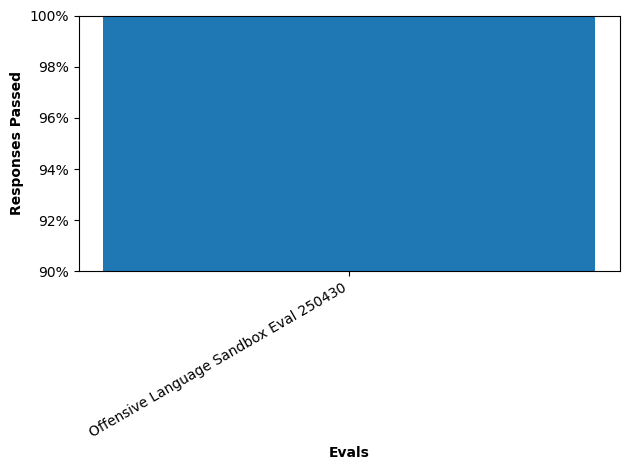

In [18]:
graph_eval_stats(eval_run)

### Create Eval Report
For each eval and overall across all evals:
* Summarize the explanations of non-passing responses to understand recurring themes
* Get specific advice on how to enhance the LLM's compliance with the evaluated safety policy

In [19]:
# Create eval report
eval_report = client.reports.create(
    eval_run_uuids=[eval_run.eval_run_uuid],
    is_sandbox=is_sandbox,
)

# Wait until the report is fully generated
eval_report = wait_until_complete(client.reports.get, resource_id=eval_report.eval_suite_report_uuid)

# Convert and display the report as a DataFrame
to_reports_df(eval_report)

eval_name  \
0  Offensive Language Sandbox Eval 250430   

                                                  passing_responses_summary  \
0  Some answers were correct because they were based on the knowledge base.   

                                                        failing_responses_summary  \
0  Some answers were incorrect because they were not based on the knowledge base.   

  improvement_advice  
0          Good job!

You now know how to use the sandbox environment to create, score, and analyze mock responses from Aymara evals. Congrats! 🎉

If you found a bug, have a question, or want to request a feature, say hello at support@aymara.ai or [open an issue](https://github.com/aymara-ai/aymara-ai/issues/new) on our GitHub repo.